# Emotion classification with fine-tuned models

In [3]:
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np

## Load data

In [4]:
df = pd.read_csv('./data/fer2013.csv')

CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']
NUM_CLASSES = len(CLASS_LABELS)
label_dict = {i:CLASS_LABELS[i] for i in np.arange(NUM_CLASSES)}

# Transform df column with pixels into a pytorch tensor
pixels = df['pixels']
pixels = pixels.apply(lambda x: x.split(" ")).tolist()
pixels = np.uint8(pixels)
pixels = torch.Tensor(pixels)
pixels = torch.reshape(pixels, (pixels.shape[0], 1, 48, 48))

train_idx = df.index[df['Usage'] == 'Training'].tolist()
val_idx   = df.index[df['Usage'] == 'PublicTest'].tolist()
test_idx  = df.index[df['Usage'] == 'PrivateTest'].tolist()

X_train = pixels[train_idx]
y_train = torch.Tensor(df.iloc[train_idx]['emotion'].tolist())
X_val = pixels[val_idx]
y_val = torch.Tensor(df.iloc[val_idx]['emotion'].tolist())
X_test = pixels[test_idx]
y_test = torch.Tensor(df.iloc[test_idx]['emotion'].tolist())

## Create dataloaders

In [5]:
class EmotionDataset(Dataset):
    '''
    Inputs:
    - images: a [Batch size, Channels, Height, Width] tensor
    - labels: a 1-dimensional tensor corresponding to image labels
    - train: True if you want to apply transformations, False otherwise
    '''
    
    def __init__(self, images, labels, train:bool):
        self.images = images / 255
        self.labels = labels
        self.train  = train
        

    def __getitem__(self, index):
        
        # Load the image (as tensor)
        img  = torch.cat((self.images[index], self.images[index], self.images[index]), 0)
        label = self.labels[index]
        
        # Apply transformations
        if self.train == True:
            img = self.transform(img)

        # Turn on gradient for image
        img = img.detach().clone().requires_grad_(True)
        
        return img, label

    
    def __len__(self):
        return len(self.images)
    
    
    def transform(self, img):
      
        if np.random.rand() < 0.3:
            t_horizonal_flip = T.RandomHorizontalFlip(p=1)
            img = t_horizonal_flip(img)

        if np.random.rand() < 0.3:
            t_rotation = T.RandomRotation(degrees=(-20, 20))
            img = t_rotation(img)

        return img

In [6]:
train_dataset = EmotionDataset(X_train, y_train, train=True)
val_dataset   = EmotionDataset(X_val, y_val, train=False)

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader   = DataLoader(val_dataset  , batch_size=256, shuffle=False)

# Define model

In [18]:
from torchvision import models
from torchvision.models import ResNet18_Weights


device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)  
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, NUM_CLASSES)
model = model.to(device) 
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

## Training

In [20]:
epochs = 10
history = []

for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        images, labels = batch
        images = images
        predictions = model.forward(images.to(device))
        loss = criterion(predictions, labels.type(torch.LongTensor).to(device))
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

    model.eval()
    val_losses = []
    val_accuracies = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            images, labels = batch
            images = images
            predictions = model.forward(images.to(device))
            loss = criterion(predictions, labels.type(torch.LongTensor).to(device))
            val_losses.append(loss.item())
            accuracy = torch.mean((torch.argmax(predictions, axis=1).cpu() == labels).float()).item()
            val_accuracies.append(accuracy)
    scheduler.step()
    result = {'train_loss': torch.mean(torch.tensor(train_losses)), 'val_loss': torch.mean(torch.tensor(val_losses)), 'val_acc': torch.mean(torch.tensor(val_accuracies))}
    history.append(result)
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch + 1, result['train_loss'], result['val_loss'], result['val_acc']))

100%|██████████| 15/15 [00:00<00:00, 50.94it/s]


Epoch [1], train_loss: 1.2087, val_loss: 1.2940, val_acc: 0.5201


100%|██████████| 15/15 [00:00<00:00, 57.52it/s]


Epoch [2], train_loss: 1.0980, val_loss: 1.2997, val_acc: 0.4925


100%|██████████| 15/15 [00:00<00:00, 57.50it/s]


Epoch [3], train_loss: 1.0134, val_loss: 1.1018, val_acc: 0.5916


100%|██████████| 15/15 [00:00<00:00, 57.80it/s]


Epoch [4], train_loss: 0.9601, val_loss: 1.1240, val_acc: 0.5790


100%|██████████| 15/15 [00:00<00:00, 58.68it/s]


Epoch [5], train_loss: 0.8990, val_loss: 1.0737, val_acc: 0.6135


100%|██████████| 15/15 [00:00<00:00, 57.67it/s]


Epoch [6], train_loss: 0.8339, val_loss: 1.1286, val_acc: 0.5884


100%|██████████| 15/15 [00:00<00:00, 44.88it/s]


Epoch [7], train_loss: 0.7872, val_loss: 1.1736, val_acc: 0.5858


100%|██████████| 15/15 [00:00<00:00, 56.37it/s]


Epoch [8], train_loss: 0.7303, val_loss: 1.1739, val_acc: 0.6009


100%|██████████| 15/15 [00:00<00:00, 54.44it/s]


Epoch [9], train_loss: 0.6729, val_loss: 1.1005, val_acc: 0.6246


100%|██████████| 15/15 [00:00<00:00, 54.70it/s]

Epoch [10], train_loss: 0.6217, val_loss: 1.1342, val_acc: 0.6291


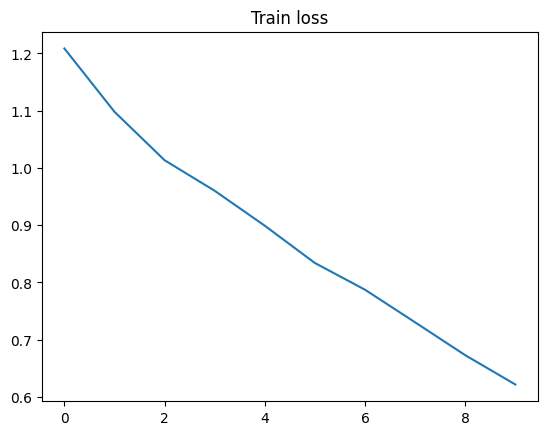

In [21]:
plt.plot([i['train_loss'].item() for i in history])
plt.title("Train loss")
plt.show()

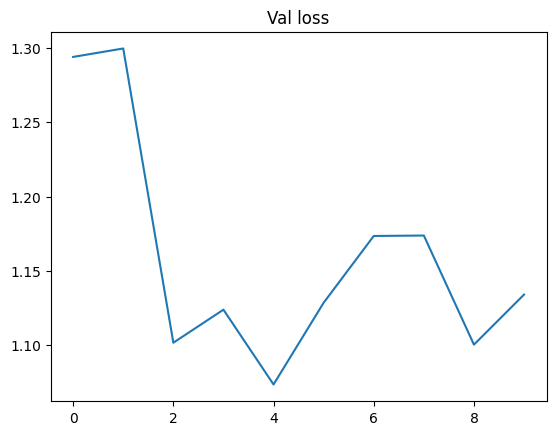

In [22]:
plt.plot([i['val_loss'].item() for i in history])
plt.title("Val loss")
plt.show()

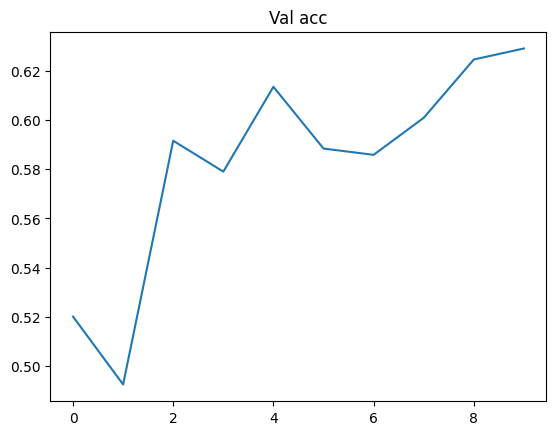

In [23]:
plt.plot([i['val_acc'].item() for i in history])
plt.title("Val acc")
plt.show()

## Save the model

In [24]:
torch.save(model, "emotion-classification/model.pth")